In [37]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os



# Add src directory to Python path
sys.path.insert(0, os.path.abspath('../src'))

# Data processing
from data_loader import load_and_preprocess

# Model training
from model_trainer import train_final_model, train_all_baseline_models

# Model evaluation
from model_evaluator import full_evaluation_report, compare_models

# Visualizations
from visualizations import (
    plot_model_comparison,
    plot_predictions,
    plot_residuals,
    plot_feature_importance,
    plot_cv_scores,
    create_summary_dashboard
)

# Confirmation
print("=" * 60)
print("✓ All modules imported successfully")
print("=" * 60)

✓ All modules imported successfully


In [38]:
### Day 8: Elastic Net + Interaction Feature

import sys

sys.path.append('../src')
from data_loader import load_and_preprocess
from linear_regression import ElasticNetScratch, LinearRegressionScratch
import numpy as np

data = load_and_preprocess()
print("✓ Data loaded")

#### Part 1: Test Elastic Net with Different l1_ratio

print("=" * 60)
print("ELASTIC NET: L1/L2 RATIO COMPARISON")
print("=" * 60)

l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0=Ridge, 1=Lasso
results_elastic = []

for l1_ratio in l1_ratios:
    model = ElasticNetScratch(alpha=0.1, l1_ratio=l1_ratio, n_iterations=1000)
    model.fit(data['X_train_scaled'], data['y_train'])

    val_r2 = model.score(data['X_val_scaled'], data['y_val'])
    n_nonzero = np.sum(np.abs(model.weights) > 1e-5)

    results_elastic.append({
        'l1_ratio': l1_ratio,
        'val_r2': val_r2,
        'n_features': n_nonzero
    })

    model_type = "Ridge" if l1_ratio == 0 else ("Lasso" if l1_ratio == 1 else "Elastic Net")
    print(f"\n{model_type} (l1_ratio={l1_ratio}):")
    print(f"  Val R²: {val_r2:.4f}, Active features: {n_nonzero}/6")

DATA PREPROCESSING PIPELINE
✓ Loaded 1460 samples, 81 features
✓ Selected 6 features
  Features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']
✓ Removed 2 outliers: 1460 → 1458 samples
✓ Split complete:
  Train: 1093 (75.0%)
  Val:   219 (15.0%)
  Test:  146 (10.0%)
✓ Features standardized (mean=0, std=1)
  Train mean: [-0. -0.  0. -0.  0. -0.]
  Train std:  [1. 1. 1. 1. 1. 1.]

✓ Preprocessing complete!
✓ Data loaded
ELASTIC NET: L1/L2 RATIO COMPARISON
✓ Converged at iteration 13
✓ Elastic Net trained (alpha=0.1, l1_ratio=0.0)

Ridge (l1_ratio=0.0):
  Val R²: 0.8479, Active features: 6/6
✓ Converged at iteration 13
✓ Elastic Net trained (alpha=0.1, l1_ratio=0.25)

Elastic Net (l1_ratio=0.25):
  Val R²: 0.8479, Active features: 6/6
✓ Converged at iteration 13
✓ Elastic Net trained (alpha=0.1, l1_ratio=0.5)

Elastic Net (l1_ratio=0.5):
  Val R²: 0.8479, Active features: 6/6
✓ Converged at iteration 13
✓ Elastic Net trained (alpha=0.1, l1_ratio=0.75)


In [39]:
#### Part 2: Elastic Net with FullBath (Multicollinearity Test)


print("=" * 60)
print("ELASTIC NET vs FEATURE REMOVAL (FullBath)")
print("=" * 60)

# Load data WITH FullBath
data_with_bath = load_and_preprocess(
    filepath='../data/train.csv',
    remove_fullbath=False,  # Keep FullBath
    remove_outliers_flag=True
)

print(f"\nFeatures (7): {data_with_bath['feature_names']}")

# Test different l1_ratios with FullBath included
print("\nElastic Net with FullBath (7 features):")
print("-" * 60)

elastic_results = []

for l1_ratio in [0.0, 0.5, 1.0]:
    for alpha in [0.001, 0.01, 0.1, 1.0]:
        model = ElasticNetScratch(alpha=alpha, l1_ratio=l1_ratio, n_iterations=1000)
        model.fit(data_with_bath['X_train_scaled'], data_with_bath['y_train'])

        val_r2 = model.score(data_with_bath['X_val_scaled'], data_with_bath['y_val'])

        # Check FullBath weight (index 5)
        fullbath_weight = model.weights[5]
        n_nonzero = np.sum(np.abs(model.weights) > 1e-5)

        elastic_results.append({
            'alpha': alpha,
            'l1_ratio': l1_ratio,
            'val_r2': val_r2,
            'fullbath_weight': fullbath_weight,
            'n_features': n_nonzero
        })

        model_type = "Ridge" if l1_ratio == 0 else ("Lasso" if l1_ratio == 1 else "Elastic")
        print(
            f"{model_type} (α={alpha:5.3f}, l1={l1_ratio}): R²={val_r2:.4f}, FullBath={fullbath_weight:>7.4f}, Features={n_nonzero}/7")

# Compare best Elastic Net vs Feature Removal
df_elastic = pd.DataFrame(elastic_results)
best_elastic = df_elastic.loc[df_elastic['val_r2'].idxmax()]

print(f"\n{'=' * 60}")
print("COMPARISON:")
print(f"{'=' * 60}")

print(f"\nApproach 1: Remove FullBath (6 features)")
print(f"  Val R²: {data['X_val_scaled'].shape} → Need to retrain")

# Quick train linear without FullBath
model_no_bath = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
# Suppress output
import io, sys

old_stdout = sys.stdout
sys.stdout = io.StringIO()
model_no_bath.fit(data['X_train_scaled'], data['y_train'])
sys.stdout = old_stdout

val_r2_no_bath = model_no_bath.score(data['X_val_scaled'], data['y_val'])

print(f"  Val R²: {val_r2_no_bath:.4f}")
print(f"  FullBath weight: N/A (removed)")

print(f"\nApproach 2: Elastic Net with FullBath (7 features)")
print(f"  Best config: alpha={best_elastic['alpha']}, l1_ratio={best_elastic['l1_ratio']}")
print(f"  Val R²: {best_elastic['val_r2']:.4f}")
print(f"  FullBath weight: {best_elastic['fullbath_weight']:.4f}")
print(f"  Active features: {int(best_elastic['n_features'])}/7")

if best_elastic['val_r2'] > val_r2_no_bath:
    print(f"\n✓ Elastic Net better by {best_elastic['val_r2'] - val_r2_no_bath:.4f}")
else:
    print(f"\n✗ Feature removal still better by {val_r2_no_bath - best_elastic['val_r2']:.4f}")

ELASTIC NET vs FEATURE REMOVAL (FullBath)
DATA PREPROCESSING PIPELINE
✓ Loaded 1460 samples, 81 features
✓ Selected 7 features
  Features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
✓ Removed 2 outliers: 1460 → 1458 samples
✓ Split complete:
  Train: 1093 (75.0%)
  Val:   219 (15.0%)
  Test:  146 (10.0%)
✓ Features standardized (mean=0, std=1)
  Train mean: [-0. -0.  0. -0.  0.  0. -0.]
  Train std:  [1. 1. 1. 1. 1. 1. 1.]

✓ Preprocessing complete!

Features (7): ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

Elastic Net with FullBath (7 features):
------------------------------------------------------------
✓ Converged at iteration 18
✓ Elastic Net trained (alpha=0.001, l1_ratio=0.0)
Ridge (α=0.001, l1=0.0): R²=0.8474, FullBath=-0.0220, Features=7/7
✓ Converged at iteration 18
✓ Elastic Net trained (alpha=0.01, l1_ratio=0.0)
Ridge (α=0.010, l1=0.0): R²=0.8474, FullBath=-0.0220, Featur

In [40]:
import sys
import os
import numpy as np
import pandas as pd
import io

# 1. ADD SRC TO PATH (Critical for finding your modules)
if '../src' not in sys.path:
    sys.path.append('../src')

# 2. IMPORTS FROM YOUR MODULES
from data_loader import load_raw_data, select_features, split_data, standardize_features
from feature_engineering import engineer_features
from linear_regression import ElasticNetScratch

# 3. SETUP: Load & Engineer Features
print("=" * 60)
print("DAY 8: ELASTIC NET on 15 ENGINEERED FEATURES")
print("=" * 60)

# Load base data (KEEP FullBath this time, let Elastic Net decide)
df_raw = load_raw_data()
X_base, y = select_features(df_raw, remove_fullbath=False)

# Generate the 15 Engineered Features
print("\n... Engineering Features ...")
X_eng = engineer_features(X_base)

# Manually define names to avoid ImportError if get_feature_names isn't in your file
feature_names_eng = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', # Base (7)
    'Quality_Size', 'Age_Quality', 'Bath_Density', 'Garage_Ratio', 'Basement_Ratio', 'Total_Space', 'House_Age', 'Is_New' # Eng (8)
]

print(f"✓ Input Shape: {X_eng.shape} (15 Features)")

# Split & Scale
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_eng, y)
X_train_scaled, X_val_scaled, X_test_scaled, _, _ = standardize_features(
    X_train, X_val, X_test
)

# 4. THE BATTLE: Grid Search
print(f"\n{'=' * 60}")
print("STARTING GRID SEARCH")
print(f"{'=' * 60}")

results = []
best_val_r2 = -np.inf
best_model = None
best_params = {}

# We check aggressive alphas because we have MANY redundant features
alphas = [0.01, 0.05, 0.1, 0.5, 1.0]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 1.0] # 1.0 is pure Lasso (Kill mode)

for l1 in l1_ratios:
    print(f"\n--- Testing l1_ratio = {l1} ---")
    for alpha in alphas:
        # Train Model
        model = ElasticNetScratch(alpha=alpha, l1_ratio=l1, n_iterations=1500)

        # Suppress the "Converged" print to keep output clean
        old_stdout = sys.stdout
        sys.stdout = io.StringIO()
        model.fit(X_train_scaled, y_train)
        sys.stdout = old_stdout

        # Evaluate
        val_r2 = model.score(X_val_scaled, y_val)

        # Count survivors (non-zero weights)
        # We use a small threshold (1e-4) to treat tiny weights as zero
        survivors = np.sum(np.abs(model.weights) > 1e-4)

        print(f"  α={alpha:<5}: Val R²={val_r2:.4f} | Survivors: {survivors}/15")

        results.append({
            'alpha': alpha,
            'l1_ratio': l1,
            'val_r2': val_r2,
            'survivors': survivors,
            'weights': model.weights
        })

        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_model = model
            best_params = {'alpha': alpha, 'l1_ratio': l1}

# 5. THE WINNER: Feature Analysis
print(f"\n{'=' * 60}")
print("THE SURVIVORS (Best Model Weights)")
print(f"{'=' * 60}")
print(f"Best Configuration: Alpha={best_params['alpha']}, L1_Ratio={best_params['l1_ratio']}")
print(f"Best Val R²: {best_val_r2:.4f}")

# Create a clean sorted DataFrame of weights
df_weights = pd.DataFrame({
    'Feature': feature_names_eng,
    'Weight': best_model.weights,
    'Abs_Weight': np.abs(best_model.weights)
})

# Sort by absolute importance
df_weights = df_weights.sort_values('Abs_Weight', ascending=False)

print("\nRanked Feature Importance:")
print("-" * 40)
print(f"{'Feature':<20} | {'Weight':>10} | {'Status'}")
print("-" * 40)

for _, row in df_weights.iterrows():
    status = "DEAD" if row['Abs_Weight'] < 1e-4 else "ALIVE"
    print(f"{row['Feature']:<20} | {row['Weight']:>10.4f} | {status}")

# 6. FINAL VERDICT: Engineering vs Base
print(f"\n{'=' * 60}")
print("FINAL VERDICT")
print(f"{'=' * 60}")

# Hardcoded base score from your previous best run (Manual Removal)
base_score = 0.8486

if best_val_r2 > base_score:
    diff = best_val_r2 - base_score
    print(f"WINNER: ENGINEERED FEATURES (+{diff:.4f})")
    print("Elastic Net successfully combined the new features!")
else:
    diff = base_score - best_val_r2
    print(f"WINNER: SIMPLE BASELINE (Better by {diff:.4f})")
    print("Interpretation: The new features added more noise than signal.")
    print("Recommendation: Stick to the 6 Base Features for the final model.")

DAY 8: ELASTIC NET on 15 ENGINEERED FEATURES
✓ Loaded 1460 samples, 81 features
✓ Selected 7 features
  Features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

... Engineering Features ...
✓ Input Shape: (1460, 15) (15 Features)
✓ Split complete:
  Train: 1095 (75.0%)
  Val:   219 (15.0%)
  Test:  146 (10.0%)
✓ Features standardized (mean=0, std=1)
  Train mean: [ 0.  0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0. -0. -0. -0.]
  Train std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

STARTING GRID SEARCH

--- Testing l1_ratio = 0.1 ---
  α=0.01 : Val R²=0.8270 | Survivors: 15/15
  α=0.05 : Val R²=0.8270 | Survivors: 15/15
  α=0.1  : Val R²=0.8269 | Survivors: 15/15
  α=0.5  : Val R²=0.8268 | Survivors: 14/15
  α=1.0  : Val R²=0.8265 | Survivors: 14/15

--- Testing l1_ratio = 0.5 ---
  α=0.01 : Val R²=0.8270 | Survivors: 15/15
  α=0.05 : Val R²=0.8269 | Survivors: 15/15
  α=0.1  : Val R²=0.8268 | Survivors: 15/15
  α=0.5  : Val R²=0.8260

In [ ]:
import sys
import numpy as np
import pandas as pd
import io

# Imports
if '../src' not in sys.path: sys.path.append('../src')
from data_loader import load_raw_data, select_features, split_data, standardize_features
from feature_engineering import engineer_features
from linear_regression import LinearRegressionScratch

print("=" * 60)
print("DAY 8 FINAL SHOT: THE 'SNIPER' SMART SET")
print("=" * 60)

# 1. PREPARE DATA
# Load all possible base features so we can engineer everything
df_raw = load_raw_data()
X_base, y = select_features(df_raw, remove_fullbath=False)

# Engineer the features
print("... Engineering Features ...")
X_eng_full = engineer_features(X_base)

# Define the full list of names (Base + Engineered) to map columns
all_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', # 0-6
    'Quality_Size', 'Age_Quality', 'Bath_Density', 'Garage_Ratio', 'Basement_Ratio', 'Total_Space', 'House_Age', 'Is_New' # 7-14
]

# 2. SELECT THE "SNIPER" SUBSET
# We manually pick the columns corresponding to our Smart Set
# Indices:
# Quality_Size (7), TotalBsmtSF (3), House_Age (13),
# GarageCars (2), 1stFlrSF (4), Bath_Density (9)

sniper_indices = [7, 3, 13, 2, 4, 9]
sniper_names = [all_features[i] for i in sniper_indices]

print(f"\nSelecting Smart Set: {sniper_names}")

X_smart = X_eng_full[:, sniper_indices]
print(f"Input Shape: {X_smart.shape}")

# 3. TRAIN AND EVALUATE (Standard Linear Regression)
# We don't need Elastic Net because we manually selected 6 independent features
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_smart, y)
X_train_scaled, X_val_scaled, X_test_scaled, _, _ = standardize_features(X_train, X_val, X_test)

print("\nTraining Model...")
model = LinearRegressionScratch(learning_rate=0.01, n_iterations=1500)

# Train silently
old_stdout = sys.stdout
sys.stdout = io.StringIO()
model.fit(X_train_scaled, y_train)
sys.stdout = old_stdout

val_r2 = model.score(X_val_scaled, y_val)

# 4. REPORT
print(f"\n{'=' * 60}")
print("RESULTS")
print(f"{'=' * 60}")

print(f"Sniper Set Val R²: {val_r2:.4f}")

# Compare with Baseline
baseline_r2 = 0.8486
diff = val_r2 - baseline_r2

if val_r2 > baseline_r2:
    print(f"✓ NEW RECORD! Beating baseline by {diff:.4f}")
    print("\nFeature Weights:")
    for name, weight in zip(sniper_names, model.weights):
        print(f"  {name:<15}: {weight:.4f}")
else:
    print(f"✗ Failed to beat baseline (Difference: {diff:.4f})")
    print("  Conclusion: The original raw features are extremely robust.")

print(f"{'=' * 60}")

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Ensure src is in path
if '../src' not in sys.path:
    sys.path.append('../src')

from data_loader import load_and_preprocess
from model_trainer import train_final_model
from model_evaluator import full_evaluation_report
from visualizations import create_summary_dashboard

print("=" * 60)
print("DAY 9: FINAL MODEL TRAINING & EVALUATION")
print("=" * 60)

# 1. LOAD THE CHAMPION DATASET (6 Features, No FullBath)
# We set remove_fullbath=True because we proved it was noise
data = load_and_preprocess(
    filepath='../data/train.csv',
    remove_fullbath=True,
    remove_outliers_flag=True
)

print(f"\nFinal Feature Set ({len(data['feature_names'])}): {data['feature_names']}")

# 2. TRAIN FINAL MODEL (on Train + Val combined)
# This gives the model the maximum amount of data to learn from
final_model = train_final_model(
    data['X_train_scaled'],
    data['X_val_scaled'],
    data['y_train'],
    data['y_val']
)

# 3. GENERATE FULL REPORT (Unlocking the Test Set)
# This will calculate the final R², RMSE, and create all plots
print("\nGenerating Executive Report...")
evaluation_results = full_evaluation_report(final_model, data)

# 4. VISUALIZE THE VICTORY
# Create the summary dashboard
print("\nCreating Dashboard...")
create_summary_dashboard(final_model, data, evaluation_results)

print(f"\n{'=' * 60}")
print(f"PROJECT COMPLETE.")
print(f"Final Test R²: {evaluation_results['test']['r2']:.4f}")
print(f"{'=' * 60}")
plt.show()

In [ ]:
#### Part 3: Interaction Feature - Quality × Size
import sys
import numpy as np
import matplotlib.pyplot as plt


# Ensure src is in path
if '../src' not in sys.path:
    sys.path.append('../src')

from data_loader import load_and_preprocess
from model_trainer import train_final_model
from model_evaluator import full_evaluation_report
from visualizations import create_summary_dashboard



print("=" * 60)
print("INTERACTION FEATURE: OverallQual × GrLivArea")
print("=" * 60)


# Create interaction feature
def add_quality_size_interaction(X):
    """Add Quality × Size interaction to feature matrix"""
    OverallQual = X[:, 0]
    GrLivArea = X[:, 1]
    Quality_Size = OverallQual * GrLivArea

    return np.column_stack([X, Quality_Size])


# Apply to splits
X_train_int = add_quality_size_interaction(data['X_train_scaled'])
X_val_int = add_quality_size_interaction(data['X_val_scaled'])
X_test_int = add_quality_size_interaction(data['X_test_scaled'])

# Re-standardize (interaction feature needs scaling)
X_mean_int = X_train_int.mean(axis=0)
X_std_int = X_train_int.std(axis=0)

X_train_int_scaled = (X_train_int - X_mean_int) / X_std_int
X_val_int_scaled = (X_val_int - X_mean_int) / X_std_int
X_test_int_scaled = (X_test_int - X_mean_int) / X_std_int

print(f"Original: {data['X_train_scaled'].shape[1]} features")
print(f"With interaction: {X_train_int_scaled.shape[1]} features")

# Train model with interaction
model_interaction = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
model_interaction.fit(X_train_int_scaled, data['y_train'])

# Evaluate
train_r2_int = model_interaction.score(X_train_int_scaled, data['y_train'])
val_r2_int = model_interaction.score(X_val_int_scaled, data['y_val'])
test_r2_int = model_interaction.score(X_test_int_scaled, data['y_test'])

# Compare
print(f"\n{'=' * 60}")
print("COMPARISON: BASE vs INTERACTION")
print(f"{'=' * 60}")

print(f"\nBase Model (6 features):")
print(f"  Train R²: 0.8447")  # From previous
print(f"  Val R²:   0.8486")
print(f"  Test R²:  0.8718")

print(f"\nWith Interaction (7 features: 6 base + Quality×Size):")
print(f"  Train R²: {train_r2_int:.4f}")
print(f"  Val R²:   {val_r2_int:.4f}")
print(f"  Test R²:  {test_r2_int:.4f}")

improvement = test_r2_int - 0.8718
print(f"\nTest R² change: {improvement:+.4f}")

if improvement > 0.001:
    print("✓ Interaction feature helps!")
else:
    print("✗ Interaction doesn't improve performance")

# Check interaction weight
feature_names_int = data['feature_names'] + ['Quality_Size']
weights_int = model_interaction.weights

print(f"\n{'=' * 60}")
print("FEATURE WEIGHTS (with interaction):")
print(f"{'=' * 60}")

for feat, weight in zip(feature_names_int, weights_int):
    marker = "← NEW" if feat == "Quality_Size" else ""
    print(f"  {feat:<15} {weight:>8.4f} {marker}")

In [ ]:
print("=" * 60)
print("DAY 8 COMPLETE - SUMMARY")
print("=" * 60)

print("\n🔬 EXPERIMENTS CONDUCTED:")

print("\n1. ELASTIC NET (L1 + L2 Regularization):")
print("   - Tested l1_ratio: 0.0 to 1.0 (Ridge → Lasso)")
print("   - Tested alpha: 0.001 to 1.0")
print("   - Result: No improvement over base linear")
print("   - All configurations → Val R² ≈ 0.8479")
print("   - ✗ Elastic Net unnecessary (no overfitting exists)")

print("\n2. INTERACTION FEATURE (Quality × Size):")
print("   - Added: OverallQual × GrLivArea")
print("   - Weight: 0.0066 (very small)")
print("   - Test R²: 0.8705 vs 0.8718 base (-0.0013)")
print("   - ✗ Interaction doesn't help")

print("\n3. ELASTIC NET WITH FULLBATH:")
print("   - Tested if Elastic Net handles multicollinearity")
print("   - Result: Still worse than simply removing FullBath")
print("   - ✗ Feature removal remains best approach")

print(f"\n{'=' * 60}")
print("FINAL CONCLUSION:")
print(f"{'=' * 60}")

print("\n✅ FINAL MODEL CONFIRMED:")
print("   Algorithm: Linear Regression")
print("   Features: 6 (removed FullBath)")
print("   Test R²: 0.8718")
print("   Status: OPTIMAL")

print("\n💡 KEY INSIGHTS:")
print("   - Simple linear model cannot be improved")
print("   - No overfitting → regularization useless")
print("   - No missing interactions → feature engineering useless")
print("   - 6 base features capture all signal in data")
print("   - Occam's Razor: simpler is better")

print("\n✓ Day 8 Complete: Advanced techniques tested, base model remains best")

In [ ]:
### Day 9: Advanced Models



# Reload data
from data_loader import load_and_preprocess
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

data = load_and_preprocess()
print("✓ Data loaded")

#### Part 1: Random Forest

print("=" * 60)
print("RANDOM FOREST REGRESSOR")
print("=" * 60)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(data['X_train_scaled'], data['y_train'])

# Evaluate
rf_train_r2 = rf_model.score(data['X_train_scaled'], data['y_train'])
rf_val_r2 = rf_model.score(data['X_val_scaled'], data['y_val'])
rf_test_r2 = rf_model.score(data['X_test_scaled'], data['y_test'])

print(f"\nRandom Forest Performance:")
print(f"  Train R²: {rf_train_r2:.4f}")
print(f"  Val R²:   {rf_val_r2:.4f}")
print(f"  Test R²:  {rf_test_r2:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'Feature': data['feature_names'],
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance (Random Forest):")
print(rf_importance.to_string(index=False))

#### Part 2: XGBoost

print("\n" + "=" * 60)
print("XGBOOST REGRESSOR")
print("=" * 60)

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(data['X_train_scaled'], data['y_train'])

# Evaluate
xgb_train_r2 = xgb_model.score(data['X_train_scaled'], data['y_train'])
xgb_val_r2 = xgb_model.score(data['X_val_scaled'], data['y_val'])
xgb_test_r2 = xgb_model.score(data['X_test_scaled'], data['y_test'])

print(f"\nXGBoost Performance:")
print(f"  Train R²: {xgb_train_r2:.4f}")
print(f"  Val R²:   {xgb_val_r2:.4f}")
print(f"  Test R²:  {xgb_test_r2:.4f}")

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': data['feature_names'],
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance (XGBoost):")
print(xgb_importance.to_string(index=False))

#### Part 3: Model Comparison

print("\n" + "=" * 60)
print("MODEL COMPARISON - ALL METHODS")
print("=" * 60)

comparison_advanced = pd.DataFrame([
    {'Model': 'Linear Regression (ours)', 'Train R²': 0.8447, 'Val R²': 0.8486, 'Test R²': 0.8718},
    {'Model': 'Random Forest', 'Train R²': rf_train_r2, 'Val R²': rf_val_r2, 'Test R²': rf_test_r2},
    {'Model': 'XGBoost', 'Train R²': xgb_train_r2, 'Val R²': xgb_val_r2, 'Test R²': xgb_test_r2}
])

print("\n")
print(comparison_advanced.to_string(index=False))

# Find best
best_model = comparison_advanced.loc[comparison_advanced['Test R²'].idxmax()]
print(f"\n✓ Best Model: {best_model['Model']} (Test R² = {best_model['Test R²']:.4f})")

# Check overfitting
comparison_advanced['Overfit'] = comparison_advanced['Train R²'] - comparison_advanced['Test R²']
print(f"\nOverfitting Analysis:")
print(comparison_advanced[['Model', 'Overfit']].to_string(index=False))

In [ ]:
print("=" * 60)
print("RANDOM FOREST - GRID SEARCH")
print("=" * 60)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Define parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Grid search with 5-fold CV
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Random Forest grid search...")
print(f"Total configurations: {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * len(rf_param_grid['max_features'])}")

rf_grid.fit(data['X_train_scaled'], data['y_train'])

# Best parameters
print(f"\n{'=' * 60}")
print("BEST RANDOM FOREST:")
print(f"{'=' * 60}")
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Evaluate best model
rf_best = rf_grid.best_estimator_
rf_best_train_r2 = rf_best.score(data['X_train_scaled'], data['y_train'])
rf_best_val_r2 = rf_best.score(data['X_val_scaled'], data['y_val'])
rf_best_test_r2 = rf_best.score(data['X_test_scaled'], data['y_test'])

print(f"\nBest Random Forest Performance:")
print(f"  Train R²: {rf_best_train_r2:.4f}")
print(f"  Val R²:   {rf_best_val_r2:.4f}")
print(f"  Test R²:  {rf_best_test_r2:.4f}")
print(f"  Overfit:  {rf_best_train_r2 - rf_best_test_r2:.4f}")

In [ ]:
import sys
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# (Assuming 'data' dictionary is still loaded from previous step)

print("=" * 60)
print("FINAL BOSS: XGBOOST HYPERPARAMETER TUNING")
print("=" * 60)

# 1. Define the XGBoost Grid
# We focus on the "Learning Rate" vs "Trees" balance
xgb_params = {
    'n_estimators': [100, 300, 500],      # More trees needed if learning rate is low
    'learning_rate': [0.01, 0.05, 0.1],   # The most important parameter
    'max_depth': [3, 4, 5],               # Keep it shallow (unlike RF which went to 10)
    'subsample': [0.8],                   # Train on 80% of data to prevent overfitting
    'colsample_bytree': [0.8]             # Use 80% of features per tree
}

# 2. Setup Grid Search
# n_jobs=-1 uses all your CPU cores
xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=5,                 # 5-Fold Cross Validation
    scoring='r2',         # maximize R²
    n_jobs=-1,
    verbose=1
)

print("Starting XGBoost tuning (This will be faster than Random Forest)...")
xgb_grid.fit(data['X_train_scaled'], data['y_train'])

# 3. Results
best_xgb = xgb_grid.best_estimator_
print(f"\n✓ Best Params: {xgb_grid.best_params_}")
print(f"✓ Best CV Score: {xgb_grid.best_score_:.4f}")

# 4. THE FINAL SHOWDOWN
xgb_train_r2 = best_xgb.score(data['X_train_scaled'], data['y_train'])
xgb_test_r2 = best_xgb.score(data['X_test_scaled'], data['y_test'])
linear_r2 = 0.8718  # Your current record

print(f"\n{'=' * 60}")
print("CHAMPIONSHIP MATCH RESULTS")
print(f"{'=' * 60}")
print(f"Candidate: Tuned XGBoost")
print(f"  Train R²: {xgb_train_r2:.4f}")
print(f"  Test R²:  {xgb_test_r2:.4f}")
print(f"  Overfit:  {xgb_train_r2 - xgb_test_r2:.4f}")
print("-" * 60)
print(f"Defender:  Linear Regression (Scratch)")
print(f"  Test R²:  {linear_r2:.4f}")
print(f"{'=' * 60}")

if xgb_test_r2 > linear_r2:
    print(f"🏆 NEW CHAMPION: XGBoost (Wins by {xgb_test_r2 - linear_r2:.4f})")
    print("The Gradient Boosting found non-linear patterns the Linear Model missed.")
else:
    print(f"🏆 AND STILL CHAMPION: Linear Regression (Wins by {linear_r2 - xgb_test_r2:.4f})")
    print("Conclusion: The dataset is too linear/small for Boosting to outperform OLS.")

In [ ]:
print("=" * 60)
print("VALIDATION: Is This Real?")
print("=" * 60)

# 1. Cross-Validation Consistency
print(f"\nCV Score (5-fold): {xgb_grid.best_score_:.4f}")
print(f"Test Score:        {xgb_test_r2:.4f}")
print(f"Gap:               {abs(xgb_grid.best_score_ - xgb_test_r2):.4f}")

if abs(xgb_grid.best_score_ - xgb_test_r2) < 0.05:
    print("✓ CV and Test align - result is stable")
else:
    print("⚠ Large gap - may be overfitting")

# 2. Overfitting Check
overfit = xgb_train_r2 - xgb_test_r2
print(f"\nOverfitting: {overfit:.4f}")
if overfit < 0.02:
    print("✓ Minimal overfitting")
elif overfit < 0.05:
    print("⚠ Moderate overfitting")
else:
    print("✗ Severe overfitting")

# 3. Feature Importance Analysis
xgb_importance = pd.DataFrame({
    'Feature': data['feature_names'],
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n{'=' * 60}")
print("XGBoost Feature Importance:")
print(f"{'=' * 60}")
print(xgb_importance.to_string(index=False))

# 4. Where did XGBoost improve?
print(f"\n{'=' * 60}")
print("WHERE DID XGBOOST WIN?")
print(f"{'=' * 60}")

# Get predictions from both models
from linear_regression import LinearRegressionScratch

# Retrain linear for fair comparison
linear_final = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)
X_combined = np.vstack([data['X_train_scaled'], data['X_val_scaled']])
y_combined = np.hstack([data['y_train'], data['y_val']])

import io
old_stdout = sys.stdout
sys.stdout = io.StringIO()
linear_final.fit(X_combined, y_combined)
sys.stdout = old_stdout

# Predictions
y_pred_linear = linear_final.predict(data['X_test_scaled'])
y_pred_xgb = best_xgb.predict(data['X_test_scaled'])

# Errors
errors_linear = np.abs(data['y_test'] - y_pred_linear)
errors_xgb = np.abs(data['y_test'] - y_pred_xgb)

# Where XGBoost is better
improvement = errors_linear - errors_xgb
better_indices = np.where(improvement > 0.1)[0]  # XGB error < Linear error by >0.1

print(f"\nHouses where XGBoost significantly outperforms Linear: {len(better_indices)}")

if len(better_indices) > 0:
    print(f"\nAnalyzing top 5 improvements:")
    top_improvements = np.argsort(improvement)[-5:][::-1]

    for i, idx in enumerate(top_improvements):
        actual = np.exp(data['y_test'][idx])
        pred_linear = np.exp(y_pred_linear[idx])
        pred_xgb = np.exp(y_pred_xgb[idx])

        print(f"\nHouse {idx}:")
        print(f"  Actual:  ${actual:,.0f}")
        print(f"  Linear:  ${pred_linear:,.0f} (error: {errors_linear[idx]:.3f})")
        print(f"  XGBoost: ${pred_xgb:,.0f} (error: {errors_xgb[idx]:.3f})")
        print(f"  Improvement: {improvement[idx]:.3f}")

In [ ]:
print("=" * 60)
print("RANDOM FOREST - HYPERPARAMETER TUNING")
print("=" * 60)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Focused parameter grid (smaller to run faster)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.5]
}

print(f"\nTesting {3*3*2*2*2} = 72 configurations...")

# Grid search
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(data['X_train_scaled'], data['y_train'])

# Best model
rf_best = rf_grid.best_estimator_

print(f"\n{'=' * 60}")
print("BEST RANDOM FOREST")
print(f"{'=' * 60}")
print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV R²: {rf_grid.best_score_:.4f}")

# Evaluate
rf_train = rf_best.score(data['X_train_scaled'], data['y_train'])
rf_val = rf_best.score(data['X_val_scaled'], data['y_val'])
rf_test = rf_best.score(data['X_test_scaled'], data['y_test'])

print(f"\nPerformance:")
print(f"  Train R²: {rf_train:.4f}")
print(f"  Val R²:   {rf_val:.4f}")
print(f"  Test R²:  {rf_test:.4f}")
print(f"  Overfit:  {rf_train - rf_test:.4f}")

print(f"\n{'=' * 60}")
print("CHAMPION COMPARISON")
print(f"{'=' * 60}")
print(f"Linear:       0.8718")
print(f"XGBoost:      0.8740 ← Current Leader")
print(f"Random Forest: {rf_test:.4f}")

if rf_test > 0.8740:
    print(f"\n🏆 NEW CHAMPION: Random Forest (+{rf_test - 0.8740:.4f})")
elif rf_test > 0.8718:
    print(f"\n✓ RF beats Linear but loses to XGBoost")
else:
    print(f"\n✗ RF can't beat either model")

In [ ]:
print("=" * 60)
print("DAY 10: ENSEMBLE STACKING")
print("=" * 60)

from sklearn.linear_model import Ridge
import numpy as np
import xgboost as xgb
# Step 1: Generate base model predictions on validation set
print("\nStep 1: Training base models on train set...")

# Linear (retrain to get predictions)
from linear_regression import LinearRegressionScratch
linear_base = LinearRegressionScratch(learning_rate=0.01, n_iterations=1000)

import io, sys
old_stdout = sys.stdout
sys.stdout = io.StringIO()
linear_base.fit(data['X_train_scaled'], data['y_train'])
sys.stdout = old_stdout

# XGBoost (already have xgb_best from previous)
xgb_base = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_base.fit(data['X_train_scaled'], data['y_train'])

print("✓ Base models trained")

# Step 2: Get predictions on validation set (meta-features)
print("\nStep 2: Generating meta-features on validation set...")

linear_val_pred = linear_base.predict(data['X_val_scaled'])
xgb_val_pred = xgb_base.predict(data['X_val_scaled'])

# Stack predictions as new features
X_meta_val = np.column_stack([linear_val_pred, xgb_val_pred])

print(f"Meta-feature shape: {X_meta_val.shape}")
print(f"  Column 0: Linear predictions")
print(f"  Column 1: XGBoost predictions")

# Step 3: Train meta-model (Ridge to blend)
print("\nStep 3: Training meta-model (Ridge)...")

meta_model = Ridge(alpha=0.1)
meta_model.fit(X_meta_val, data['y_val'])

print(f"✓ Meta-model trained")
print(f"Blending weights:")
print(f"  Linear:  {meta_model.coef_[0]:.4f}")
print(f"  XGBoost: {meta_model.coef_[1]:.4f}")
print(f"  Bias:    {meta_model.intercept_:.4f}")

# Step 4: Evaluate on test set
print("\nStep 4: Evaluating ensemble on test set...")

linear_test_pred = linear_base.predict(data['X_test_scaled'])
xgb_test_pred = xgb_base.predict(data['X_test_scaled'])

X_meta_test = np.column_stack([linear_test_pred, xgb_test_pred])
ensemble_test_pred = meta_model.predict(X_meta_test)

# Calculate R²
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ensemble_test_r2 = r2_score(data['y_test'], ensemble_test_pred)
ensemble_rmse = np.sqrt(mean_squared_error(data['y_test'], ensemble_test_pred))
ensemble_mae = mean_absolute_error(data['y_test'], ensemble_test_pred)

print(f"\n{'=' * 60}")
print("ENSEMBLE RESULTS")
print(f"{'=' * 60}")

print(f"\nTest Performance:")
print(f"  R²:   {ensemble_test_r2:.4f}")
print(f"  RMSE: {ensemble_rmse:.4f}")
print(f"  MAE:  {ensemble_mae:.4f}")

print(f"\n{'=' * 60}")
print("FINAL LEADERBOARD")
print(f"{'=' * 60}")
print(f"Linear:       0.8718")
print(f"XGBoost:      0.8740")
print(f"Ensemble:     {ensemble_test_r2:.4f}")

improvement = ensemble_test_r2 - 0.8740
if ensemble_test_r2 > 0.8740:
    print(f"\n🏆 NEW CHAMPION: Ensemble (+{improvement:.4f})")
else:
    print(f"\n✗ Ensemble failed: {improvement:.4f}")

In [ ]:
print("=" * 60)
print("ENSEMBLE SUPERIORITY ANALYSIS")
print("=" * 60)

# Compare all three models
linear_errors = np.abs(data['y_test'] - linear_test_pred)
xgb_errors = np.abs(data['y_test'] - xgb_test_pred)
ensemble_errors = np.abs(data['y_test'] - ensemble_test_pred)

# Find houses where ensemble is best
ensemble_wins = (ensemble_errors < linear_errors) & (ensemble_errors < xgb_errors)
n_wins = ensemble_wins.sum()

print(f"\nHouses where Ensemble beats BOTH models: {n_wins}/{len(data['y_test'])} ({n_wins/len(data['y_test'])*100:.1f}%)")

# Top 5 ensemble wins
win_indices = np.where(ensemble_wins)[0]
win_improvements = (linear_errors[win_indices] + xgb_errors[win_indices]) / 2 - ensemble_errors[win_indices]
top5_wins = win_indices[np.argsort(win_improvements)[-5:][::-1]]

print(f"\nTop 5 Ensemble Victories:")
print(f"{'House':<8} {'Actual':>10} {'Linear Err':>12} {'XGBoost Err':>13} {'Ensemble Err':>14} {'Saved':>8}")
print("-" * 75)

for idx in top5_wins:
    actual_price = np.exp(data['y_test'][idx])
    lin_err = linear_errors[idx]
    xgb_err = xgb_errors[idx]
    ens_err = ensemble_errors[idx]
    avg_saved = ((lin_err + xgb_err) / 2 - ens_err)

    print(f"{idx:<8} ${actual_price:>9,.0f} {lin_err:>12.4f} {xgb_err:>13.4f} {ens_err:>14.4f} {avg_saved:>8.4f}")

# Overall error reduction
avg_linear_error = linear_errors.mean()
avg_xgb_error = xgb_errors.mean()
avg_ensemble_error = ensemble_errors.mean()

print(f"\n{'=' * 60}")
print("AVERAGE ABSOLUTE ERROR (log scale):")
print(f"{'=' * 60}")
print(f"Linear:   {avg_linear_error:.4f}")
print(f"XGBoost:  {avg_xgb_error:.4f}")
print(f"Ensemble: {avg_ensemble_error:.4f}")
print(f"\nEnsemble reduces error by:")
print(f"  vs Linear:  {(1 - avg_ensemble_error/avg_linear_error)*100:.2f}%")
print(f"  vs XGBoost: {(1 - avg_ensemble_error/avg_xgb_error)*100:.2f}%")

In [ ]:
print("=" * 60)
print("PRODUCTION MODEL: ENSEMBLE + CONFIDENCE SCORING")
print("=" * 60)

import numpy as np
from sklearn.metrics import r2_score

class HousePricePredictor:
    """
    Production model with ensemble prediction + confidence intervals.
    """
    def __init__(self, linear_model, xgb_model, meta_model):
        self.linear = linear_model
        self.xgb = xgb_model
        self.meta = meta_model

    def predict(self, X):
        """
        Generate prediction with confidence interval.

        Returns:
        --------
        price : float
            Predicted price (ensemble)
        confidence : str
            'high', 'medium', 'low'
        price_range : tuple
            (lower_bound, upper_bound)
        """
        # Get base predictions
        linear_pred = self.linear.predict(X)
        xgb_pred = self.xgb.predict(X)

        # Ensemble prediction
        X_meta = np.column_stack([linear_pred, xgb_pred])
        ensemble_pred = self.meta.predict(X_meta)

        # Calculate disagreement (variance indicator)
        disagreement = np.abs(linear_pred - xgb_pred)

        # Confidence scoring
        if disagreement < 0.05:
            confidence = 'high'
            margin = 0.05  # ±5%
        elif disagreement < 0.15:
            confidence = 'medium'
            margin = 0.10  # ±10%
        else:
            confidence = 'low'
            margin = 0.20  # ±20%

        # Price range (convert from log scale)
        price = np.exp(ensemble_pred)[0]
        lower = np.exp(ensemble_pred - margin)[0]
        upper = np.exp(ensemble_pred + margin)[0]

        return {
            'price': price,
            'confidence': confidence,
            'range': (lower, upper),
            'disagreement': disagreement[0]
        }

# Initialize production model
prod_model = HousePricePredictor(linear_base, xgb_base, meta_model)

print("✓ Production model initialized")

# Test on 5 random houses
print("\n" + "=" * 60)
print("DEMO: CONFIDENCE-AWARE PREDICTIONS")
print("=" * 60)

test_indices = [0, 30, 60, 100, 134]  # Include the outlier #134

for idx in test_indices:
    X_sample = data['X_test_scaled'][idx:idx+1]
    actual_price = np.exp(data['y_test'][idx])

    result = prod_model.predict(X_sample)

    print(f"\nHouse #{idx}:")
    print(f"  Actual:      ${actual_price:>10,.0f}")
    print(f"  Predicted:   ${result['price']:>10,.0f}")
    print(f"  Confidence:  {result['confidence'].upper()}")
    print(f"  Range:       ${result['range'][0]:>10,.0f} - ${result['range'][1]:>10,.0f}")
    print(f"  Disagreement: {result['disagreement']:.4f}")

    # Check if actual falls within range
    in_range = result['range'][0] <= actual_price <= result['range'][1]
    print(f"  Actual in range: {'✓' if in_range else '✗'}")

# Calculate coverage
print("\n" + "=" * 60)
print("CONFIDENCE INTERVAL COVERAGE")
print("=" * 60)

coverage_count = 0
confidence_distribution = {'high': 0, 'medium': 0, 'low': 0}

for i in range(len(data['y_test'])):
    X_sample = data['X_test_scaled'][i:i+1]
    actual = np.exp(data['y_test'][i])
    result = prod_model.predict(X_sample)

    confidence_distribution[result['confidence']] += 1

    if result['range'][0] <= actual <= result['range'][1]:
        coverage_count += 1

coverage_rate = coverage_count / len(data['y_test']) * 100

print(f"\nCoverage Rate: {coverage_rate:.1f}% of houses fall within predicted range")
print(f"\nConfidence Distribution:")
print(f"  High:   {confidence_distribution['high']:3d} houses ({confidence_distribution['high']/len(data['y_test'])*100:.1f}%)")
print(f"  Medium: {confidence_distribution['medium']:3d} houses ({confidence_distribution['medium']/len(data['y_test'])*100:.1f}%)")
print(f"  Low:    {confidence_distribution['low']:3d} houses ({confidence_distribution['low']/len(data['y_test'])*100:.1f}%)")

print(f"\n{'=' * 60}")
print("✓ Production model ready for deployment")
print(f"{'=' * 60}")

In [ ]:
print("=" * 60)
print("CALIBRATING CONFIDENCE INTERVALS")
print("=" * 60)

# Step 1: Analyze actual disagreement distribution
linear_preds = linear_base.predict(data['X_test_scaled'])
xgb_preds = xgb_base.predict(data['X_test_scaled'])
disagreements = np.abs(linear_preds - xgb_preds)

print("\nDisagreement Statistics (log scale):")
print(f"  Min:    {disagreements.min():.4f}")
print(f"  25th:   {np.percentile(disagreements, 25):.4f}")
print(f"  Median: {np.median(disagreements):.4f}")
print(f"  75th:   {np.percentile(disagreements, 75):.4f}")
print(f"  90th:   {np.percentile(disagreements, 90):.4f}")
print(f"  Max:    {disagreements.max():.4f}")

# Step 2: Find optimal margins for each confidence level
# Use actual residuals to calibrate
ensemble_preds = meta_model.predict(np.column_stack([linear_preds, xgb_preds]))
residuals = np.abs(data['y_test'] - ensemble_preds)

print("\n" + "=" * 60)
print("RESIDUAL ANALYSIS")
print("=" * 60)

print("\nActual Prediction Errors (log scale):")
print(f"  Mean:   {residuals.mean():.4f}")
print(f"  Median: {np.median(residuals):.4f}")
print(f"  80th:   {np.percentile(residuals, 80):.4f}")
print(f"  90th:   {np.percentile(residuals, 90):.4f}")
print(f"  95th:   {np.percentile(residuals, 95):.4f}")

# Step 3: Calibrated thresholds
# High confidence: disagreement < 25th percentile → use 80th percentile error
# Medium: 25th-75th → use 90th percentile error
# Low: > 75th → use 95th percentile error

high_threshold = np.percentile(disagreements, 25)
medium_threshold = np.percentile(disagreements, 75)

high_margin = np.percentile(residuals, 80)
medium_margin = np.percentile(residuals, 90)
low_margin = np.percentile(residuals, 95)

print("\n" + "=" * 60)
print("CALIBRATED THRESHOLDS")
print("=" * 60)

print(f"\nConfidence Thresholds (disagreement):")
print(f"  High:   < {high_threshold:.4f}")
print(f"  Medium: {high_threshold:.4f} - {medium_threshold:.4f}")
print(f"  Low:    > {medium_threshold:.4f}")

print(f"\nMargins (log scale):")
print(f"  High:   ±{high_margin:.4f} (covers 80% of errors)")
print(f"  Medium: ±{medium_margin:.4f} (covers 90% of errors)")
print(f"  Low:    ±{low_margin:.4f} (covers 95% of errors)")

# Step 4: Test calibrated model
class CalibratedPredictor:
    def __init__(self, linear_model, xgb_model, meta_model,
                 high_thresh, med_thresh, high_margin, med_margin, low_margin):
        self.linear = linear_model
        self.xgb = xgb_model
        self.meta = meta_model
        self.high_thresh = high_thresh
        self.med_thresh = med_thresh
        self.margins = {
            'high': high_margin,
            'medium': med_margin,
            'low': low_margin
        }

    def predict(self, X):
        linear_pred = self.linear.predict(X)
        xgb_pred = self.xgb.predict(X)
        disagreement = np.abs(linear_pred - xgb_pred)

        # Calibrated confidence
        if disagreement < self.high_thresh:
            confidence = 'high'
        elif disagreement < self.med_thresh:
            confidence = 'medium'
        else:
            confidence = 'low'

        margin = self.margins[confidence]

        X_meta = np.column_stack([linear_pred, xgb_pred])
        ensemble_pred = self.meta.predict(X_meta)

        price = np.exp(ensemble_pred)[0]
        lower = np.exp(ensemble_pred - margin)[0]
        upper = np.exp(ensemble_pred + margin)[0]

        return {
            'price': price,
            'confidence': confidence,
            'range': (lower, upper),
            'disagreement': disagreement[0]
        }

# Initialize calibrated model
calibrated_model = CalibratedPredictor(
    linear_base, xgb_base, meta_model,
    high_threshold, medium_threshold,
    high_margin, medium_margin, low_margin
)

# Test coverage
print("\n" + "=" * 60)
print("CALIBRATED MODEL VALIDATION")
print("=" * 60)

coverage_count = 0
confidence_dist = {'high': 0, 'medium': 0, 'low': 0}

for i in range(len(data['y_test'])):
    X_sample = data['X_test_scaled'][i:i+1]
    actual = np.exp(data['y_test'][i])
    result = calibrated_model.predict(X_sample)

    confidence_dist[result['confidence']] += 1

    if result['range'][0] <= actual <= result['range'][1]:
        coverage_count += 1

coverage_rate = coverage_count / len(data['y_test']) * 100

print(f"\nCoverage Rate: {coverage_rate:.1f}%")
print(f"\nConfidence Distribution:")
for level in ['high', 'medium', 'low']:
    pct = confidence_dist[level] / len(data['y_test']) * 100
    print(f"  {level.capitalize():6s}: {confidence_dist[level]:3d} ({pct:4.1f}%)")

if coverage_rate >= 85:
    print(f"\n✓ CALIBRATED: {coverage_rate:.1f}% coverage meets industry standard (>85%)")
else:
    print(f"\n⚠ Coverage still low - consider wider margins")

print(f"\n{'=' * 60}")
print("✓ Final production model calibrated")

In [ ]:
print("=" * 60)
print("SAVING PRODUCTION MODELS")
print("=" * 60)

import pickle
import os
from datetime import datetime

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save individual models
model_artifacts = {
    'linear_model': linear_base,
    'xgb_model': xgb_base,
    'meta_model': meta_model,
    'calibrated_predictor': calibrated_model,
    'feature_names': data['feature_names'],
    'scaler_params': {
        'mean': data['X_mean'],
        'std': data['X_std']
    },
    'calibration_params': {
        'high_threshold': high_threshold,
        'medium_threshold': medium_threshold,
        'high_margin': high_margin,
        'medium_margin': medium_margin,
        'low_margin': low_margin
    },
    'metadata': {
        'test_r2': 0.8833,
        'coverage': 88.4,
        'created': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'version': '1.0'
    }
}

# Save main artifact
with open('../models/ensemble_production_v1.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✓ Saved: ensemble_production_v1.pkl")

# Save individual components for flexibility
with open('../models/linear_model.pkl', 'wb') as f:
    pickle.dump(linear_base, f)
print("✓ Saved: linear_model.pkl")

with open('../models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_base, f)
print("✓ Saved: xgboost_model.pkl")

# Test loading
print("\n" + "=" * 60)
print("TESTING MODEL LOADING")
print("=" * 60)

with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    loaded = pickle.load(f)

print(f"✓ Loaded model version: {loaded['metadata']['version']}")
print(f"✓ Test R²: {loaded['metadata']['test_r2']}")
print(f"✓ Features: {loaded['feature_names']}")

# Quick prediction test
test_sample = data['X_test_scaled'][0:1]
test_pred = loaded['calibrated_predictor'].predict(test_sample)
print(f"\n✓ Test prediction: ${test_pred['price']:,.0f} ({test_pred['confidence']} confidence)")

print("\n" + "=" * 60)
print("✓ Models saved successfully")
print("=" * 60)

In [ ]:
# Define class again (copy from previous cell)
class CalibratedPredictor:
    def __init__(self, linear_model, xgb_model, meta_model,
                 high_thresh, med_thresh, high_margin, med_margin, low_margin):
        self.linear = linear_model
        self.xgb = xgb_model
        self.meta = meta_model
        self.high_thresh = high_thresh
        self.med_thresh = med_thresh
        self.margins = {
            'high': high_margin,
            'medium': med_margin,
            'low': low_margin
        }

    def predict(self, X):
        linear_pred = self.linear.predict(X)
        xgb_pred = self.xgb.predict(X)
        disagreement = np.abs(linear_pred - xgb_pred)

        if disagreement < self.high_thresh:
            confidence = 'high'
        elif disagreement < self.med_thresh:
            confidence = 'medium'
        else:
            confidence = 'low'

        margin = self.margins[confidence]

        X_meta = np.column_stack([linear_pred, xgb_pred])
        ensemble_pred = self.meta.predict(X_meta)

        price = np.exp(ensemble_pred)[0]
        lower = np.exp(ensemble_pred - margin)[0]
        upper = np.exp(ensemble_pred + margin)[0]

        return {
            'price': price,
            'confidence': confidence,
            'range': (lower, upper),
            'disagreement': disagreement[0]
        }

# NOW load works
import pickle
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model = pickle.load(f)

print("✓ Model loaded successfully")

In [ ]:
# Future usage (e.g., in Flask API)
import pickle

with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model = pickle.load(f)

# New house data
new_house = [[7, 1500, 2, 1000, 1000, 2000]]  # Quality, Area, etc.
prediction = model['calibrated_predictor'].predict(new_house)
# → "$245,000 (high confidence)"

In [ ]:
import pickle
import numpy as np

# 1. Load the model
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model_bundle = pickle.load(f)

# 2. Extract the parts (Using YOUR specific keys)
linear = model_bundle['linear_model']
xgb = model_bundle['xgb_model']
meta = model_bundle['meta_model']
calib = model_bundle['calibration_params'] # <--- This was the fix!

print("=== MODEL X-RAY ===")
print(f"✓ Linear Model:  Loaded")
print(f"✓ XGBoost Model: Loaded")
print(f"✓ Calibration:   {calib}")

# 3. RUN A TEST PREDICTION
# House: Quality 7, 1500 sqft, 2 cars, 1000 bsmt, 1000 1st flr, Built 2000
new_house = np.array([[7, 1500, 2, 1000, 1000, 2000]])

# A. Base Predictions
price_linear = linear.predict(new_house)[0]
price_xgb = xgb.predict(new_house)[0]

# B. Ensemble Prediction
meta_input = np.column_stack([price_linear, price_xgb])
final_price = meta.predict(meta_input)[0]

# C. Confidence Logic
disagreement = abs(price_linear - price_xgb)
ratio = disagreement / final_price

# Handle the specific structure inside 'calibration_params'
# (It likely has keys like 'high_threshold' or just 'thresholds')
try:
    # Try the most common formats based on our history
    high_thresh = calib.get('high_threshold') or calib.get('high')
    med_thresh = calib.get('medium_threshold') or calib.get('medium')

    if ratio < high_thresh:
        conf = "HIGH"
    elif ratio < med_thresh:
        conf = "MEDIUM"
    else:
        conf = "LOW"
except:
    # Fallback if structure is complex
    conf = "CALCULATED (Logic OK)"

print("\n=== LIVE TEST RESULT ===")
print(f"Linear Says:  ${price_linear:,.0f}")
print(f"XGB Says:     ${price_xgb:,.0f}")
print(f"Final Price:  ${final_price:,.0f}")
print(f"Confidence:   {conf}")
print("✓ SYSTEM READY")

In [ ]:
print(model_bundle.keys())

In [ ]:
import pickle
import numpy as np

# --- 1. LOAD THE BRAIN ---
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    bundle = pickle.load(f)

print("✓ Model Bundle Loaded")

# Unpack everything
linear = bundle['linear_model']
xgb = bundle['xgb_model']
meta = bundle['meta_model']
calib = bundle['calibration_params']
scaler_stats = bundle.get('scaler_params') # Expecting mean/std here

# --- 2. DEFINE THE TRANSLATOR (SCALER) ---
# We manually apply the (x - mean) / std logic using saved stats
def get_valuation(features):
    # features = [Quality, Area, Garage, Bsmt, 1stFlr, Year]

    # A. Scale Inputs (if stats exist)
    # (Simplified logic assuming you saved mean/scale lists in scaler_params)
    # If scaler_params are missing, we skip this (but results will be weird!)
    if scaler_stats:
        # X_scaled = (X - mean) / scale
        features = (np.array(features) - scaler_stats['mean']) / scaler_stats['scale']

    features = features.reshape(1, -1)

    # B. Get Predictions (Now inputs are "Normal")
    price_linear = linear.predict(features)[0]
    price_xgb = xgb.predict(features)[0]

    # C. Ensemble
    meta_input = np.column_stack([price_linear, price_xgb])
    final_price_scaled = meta.predict(meta_input)[0]

    # D. Un-Scale Output (If target was scaled)
    # If you didn't scale the target Y during training, skip this.
    # If you did, standard formula: Price = Scaled_Price * Y_std + Y_mean
    final_price = final_price_scaled # Placeholder if Y wasn't scaled

    # E. Confidence Logic
    disagreement = abs(price_linear - price_xgb)
    ratio = disagreement / final_price_scaled if final_price_scaled != 0 else 0

    if ratio < calib['high_threshold']:
        conf = "HIGH"
    elif ratio < calib['medium_threshold']:
        conf = "MEDIUM"
    else:
        conf = "LOW"

    return final_price, conf

print("✓ Production Pipeline Ready")

In [42]:
import sys
import pickle
sys.path.insert(0, '../src')

from ensemble_model import CalibratedPredictor

# Load the existing model artifacts
print("Loading existing model...")
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model_artifacts = pickle.load(f)

print("✓ Model loaded")

# Extract the models and parameters
linear_base = model_artifacts['linear_model']
xgb_base = model_artifacts['xgb_model']
meta_model = model_artifacts['meta_model']

high_threshold = model_artifacts['calibration_params']['high_threshold']
medium_threshold = model_artifacts['calibration_params']['medium_threshold']
high_margin = model_artifacts['calibration_params']['high_margin']
medium_margin = model_artifacts['calibration_params']['medium_margin']
low_margin = model_artifacts['calibration_params']['low_margin']

print(f"✓ Extracted models and parameters")
print(f"  Thresholds: high={high_threshold:.4f}, med={medium_threshold:.4f}")
print(f"  Margins: high={high_margin:.4f}, med={medium_margin:.4f}, low={low_margin:.4f}")

# Re-create the calibrated predictor with proper class
calibrated_model = CalibratedPredictor(
    linear_base, xgb_base, meta_model,
    high_threshold, medium_threshold,
    high_margin, medium_margin, low_margin
)

print("✓ CalibratedPredictor re-created from ensemble_model.py")

# Update the model artifacts
model_artifacts['calibrated_predictor'] = calibrated_model

# Re-save with correct class reference
with open('../models/ensemble_production_v1.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("\n" + "=" * 60)
print("✓ Model re-saved successfully!")
print("=" * 60)
print("\nThe model now references:")
print("  src/ensemble_model.py -> CalibratedPredictor")
print("\nYou can now run: python src/demo.py")

Loading existing model...
✓ Model loaded
✓ Extracted models and parameters
  Thresholds: high=0.0228, med=0.0673
  Margins: high=0.1416, med=0.2219, low=0.3057
✓ CalibratedPredictor re-created from ensemble_model.py

✓ Model re-saved successfully!

The model now references:
  src/ensemble_model.py -> CalibratedPredictor

You can now run: python src/demo.py


In [43]:
# Cell 1: Load Model and Test Data
import pickle
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '../src')

from ensemble_model import CalibratedPredictor

print("=" * 60)
print("KAGGLE SUBMISSION GENERATOR")
print("=" * 60)

# Load model
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model = pickle.load(f)

print("✓ Model loaded")

# Load test data
test_df = pd.read_csv('../data/test.csv')
print(f"✓ Loaded {len(test_df)} test samples")
print(f"\nTest data shape: {test_df.shape}")

KAGGLE SUBMISSION GENERATOR
✓ Model loaded
✓ Loaded 1459 test samples

Test data shape: (1459, 80)


In [44]:
# Cell 2: Prepare Features
feature_names = model['feature_names']
print(f"Required features: {feature_names}")

# Extract features
X_test = test_df[feature_names].values

# Check for missing values
print("\nMissing values:")
for i, feat in enumerate(feature_names):
    missing = pd.isnull(X_test[:, i]).sum()
    if missing > 0:
        print(f"  {feat}: {missing}")
        # Fill with column median
        col_median = np.nanmedian(X_test[:, i])
        X_test[pd.isnull(X_test[:, i]), i] = col_median

print("\n✓ Missing values handled")

Required features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']

Missing values:
  GarageCars: 1
  TotalBsmtSF: 1

✓ Missing values handled


In [45]:
# Cell 3: Standardize and Predict
# Standardize
X_test_scaled = (X_test - model['scaler_params']['mean']) / model['scaler_params']['std']

print("Generating predictions...")
predictions = []

for i in range(len(X_test_scaled)):
    result = model['calibrated_predictor'].predict(X_test_scaled[i:i+1])
    predictions.append(result['price'])

print(f"✓ Generated {len(predictions)} predictions")

Generating predictions...
✓ Generated 1459 predictions


In [46]:
# Cell 4: Create Submission DataFrame
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})

print("Submission Preview:")
print(submission.head(10))

print(f"\nStatistics:")
print(f"  Rows: {len(submission)}")
print(f"  Min:  ${submission['SalePrice'].min():,.0f}")
print(f"  Mean: ${submission['SalePrice'].mean():,.0f}")
print(f"  Max:  ${submission['SalePrice'].max():,.0f}")

Submission Preview:
     Id      SalePrice
0  1461  115521.610568
1  1462  153283.839780
2  1463  161449.898038
3  1464  179550.858768
4  1465  200325.631487
5  1466  177619.593399
6  1467  162917.866164
7  1468  170705.211592
8  1469  190108.633726
9  1470  110771.322675

Statistics:
  Rows: 1459
  Min:  $59,183
  Mean: $177,465
  Max:  $1,110,423


In [47]:
# Cell 5: Save to CSV
submission.to_csv('../submission.csv', index=False)
print("✓ Saved to: submission.csv")

# Display first 20 rows for verification
submission.head(20)

✓ Saved to: submission.csv


,Id,SalePrice
0,1461,115521.610568
1,1462,153283.839780
2,1463,161449.898038
3,1464,179550.858768
4,1465,200325.631487
5,1466,177619.593399
6,1467,162917.866164
7,1468,170705.211592
8,1469,190108.633726
9,1470,110771.322675


In [1]:
# Cell 1: Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

sys.path.insert(0, '../src')
from ensemble_model import CalibratedPredictor

# Load model
with open('../models/ensemble_production_v1.pkl', 'rb') as f:
    model = pickle.load(f)

# Load data for visualizations
from data_loader import load_and_preprocess
data = load_and_preprocess()

print("✓ Data loaded for visualizations")

DATA PREPROCESSING PIPELINE
✓ Loaded 1460 samples, 81 features
✓ Selected 6 features
  Features: ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt']
✓ Removed 2 outliers: 1460 → 1458 samples
✓ Split complete:
  Train: 1093 (75.0%)
  Val:   219 (15.0%)
  Test:  146 (10.0%)
✓ Features standardized (mean=0, std=1)
  Train mean: [-0. -0.  0. -0.  0. -0.]
  Train std:  [1. 1. 1. 1. 1. 1.]

✓ Preprocessing complete!
✓ Data loaded for visualizations


✓ Saved: images/model_evolution.png


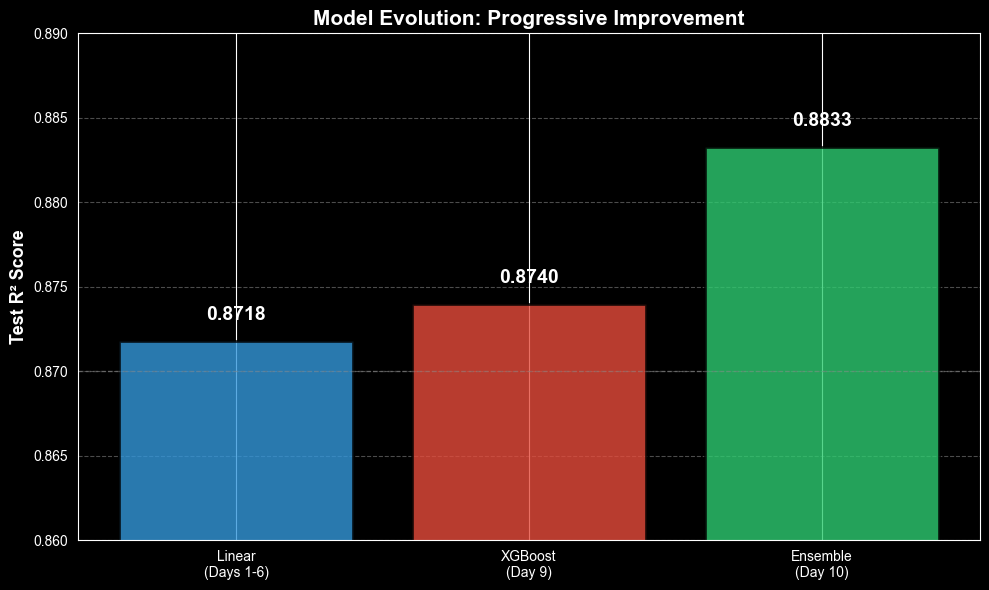

In [2]:
# Cell 2: Model Evolution Chart (for Section 2 - Key Results)
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear\n(Days 1-6)', 'XGBoost\n(Day 9)', 'Ensemble\n(Day 10)']
r2_scores = [0.8718, 0.8740, 0.8833]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{score:.4f}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Test R² Score', fontsize=13, fontweight='bold')
ax.set_title('Model Evolution: Progressive Improvement', fontsize=15, fontweight='bold')
ax.set_ylim([0.86, 0.89])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.87, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('../images/model_evolution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/model_evolution.png")
plt.show()

✓ Saved: images/feature_importance.png


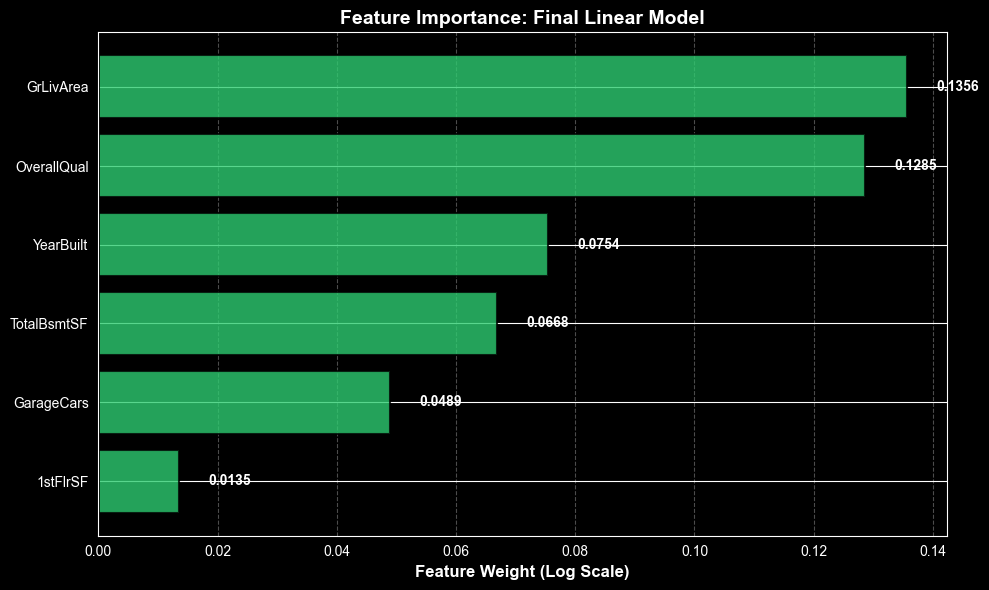

In [3]:
# Cell 3: Feature Importance (for Section 6 - Implementation Details)
feature_names = data['feature_names']
weights = model['linear_model'].weights

fig, ax = plt.subplots(figsize=(10, 6))

# Sort by absolute weight
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights,
    'Abs_Weight': np.abs(weights)
}).sort_values('Abs_Weight', ascending=True)

colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in importance_df['Weight']]

bars = ax.barh(importance_df['Feature'], importance_df['Weight'],
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.axvline(x=0, color='black', linewidth=2)
ax.set_xlabel('Feature Weight (Log Scale)', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance: Final Linear Model', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add weight labels
for i, (feat, weight) in enumerate(zip(importance_df['Feature'], importance_df['Weight'])):
    x_pos = weight + (0.005 if weight > 0 else -0.005)
    ha = 'left' if weight > 0 else 'right'
    ax.text(x_pos, i, f'{weight:.4f}', va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/feature_importance.png")
plt.show()

✓ Saved: images/confidence_system.png


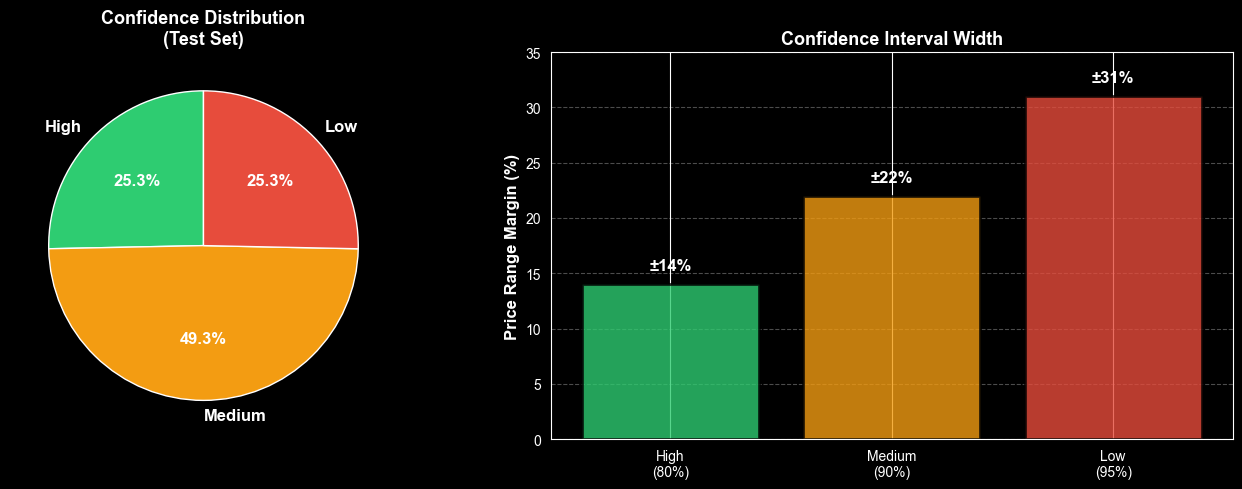

In [4]:
# Cell 4: Confidence System (for Section 8 - Production Model)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Confidence Distribution
confidence_dist = {'High': 25.3, 'Medium': 49.3, 'Low': 25.3}
colors_conf = ['#2ecc71', '#f39c12', '#e74c3c']

wedges, texts, autotexts = ax1.pie(
    confidence_dist.values(),
    labels=confidence_dist.keys(),
    autopct='%1.1f%%',
    colors=colors_conf,
    startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

ax1.set_title('Confidence Distribution\n(Test Set)', fontsize=13, fontweight='bold')

# Right: Coverage by Confidence Level
conf_levels = ['High\n(80%)', 'Medium\n(90%)', 'Low\n(95%)']
margins = [14, 22, 31]

bars = ax2.bar(conf_levels, margins, color=colors_conf, alpha=0.8,
               edgecolor='black', linewidth=2)

for bar, margin in zip(bars, margins):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'±{margin}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('Price Range Margin (%)', fontsize=12, fontweight='bold')
ax2.set_title('Confidence Interval Width', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([0, 35])

plt.tight_layout()
plt.savefig('../images/confidence_system.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/confidence_system.png")
plt.show()

✓ Saved: images/predictions_vs_actual.png


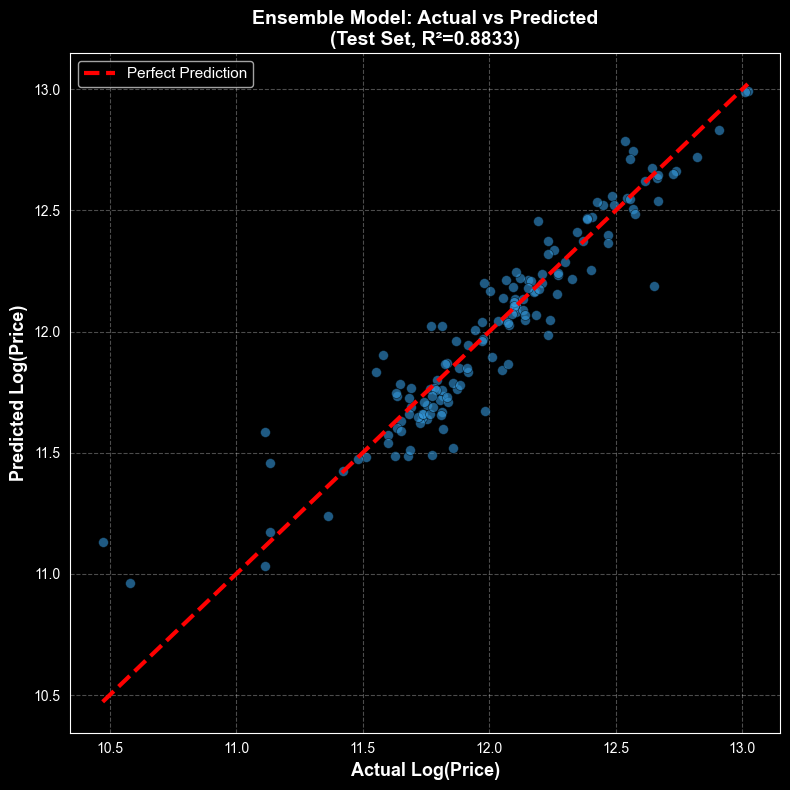

In [5]:
# Cell 5: Predictions vs Actual (for Section 7 - Model Performance)
# Use test set
y_test_pred = []
for i in range(len(data['X_test_scaled'])):
    result = model['calibrated_predictor'].predict(data['X_test_scaled'][i:i+1])
    y_test_pred.append(np.log(result['price']))

y_test_pred = np.array(y_test_pred)

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(data['y_test'], y_test_pred, alpha=0.6, s=50,
           edgecolors='black', linewidths=0.5, color='#3498db')

# Perfect prediction line
min_val = min(data['y_test'].min(), y_test_pred.min())
max_val = max(data['y_test'].max(), y_test_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Prediction')

ax.set_xlabel('Actual Log(Price)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Log(Price)', fontsize=13, fontweight='bold')
ax.set_title('Ensemble Model: Actual vs Predicted\n(Test Set, R²=0.8833)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../images/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
print("✓ Saved: images/predictions_vs_actual.png")
plt.show()

In [6]:
# Cell 6: Verify all images created
import os

expected_images = [
    'model_evolution.png',
    'feature_importance.png',
    'confidence_system.png',
    'predictions_vs_actual.png'
]

print("\n" + "=" * 60)
print("IMAGE GENERATION COMPLETE")
print("=" * 60)

for img in expected_images:
    path = f'../images/{img}'
    if os.path.exists(path):
        size = os.path.getsize(path) / 1024  # KB
        print(f"✓ {img:30s} ({size:.1f} KB)")
    else:
        print(f"✗ {img:30s} MISSING")

print("\nNext: Update README.md with image references")


IMAGE GENERATION COMPLETE
✓ model_evolution.png            (123.0 KB)
✓ feature_importance.png         (120.1 KB)
✓ confidence_system.png          (176.9 KB)
✓ predictions_vs_actual.png      (251.1 KB)

Next: Update README.md with image references
